In [116]:
import csv
import json
import os
from PIL import Image
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import pytz

from utilidades import constantes as constante


Analisis de imagenes clasificadas

In [117]:
#Leemos nuestros archivo de imagenes csv
try:
    archivo_imagenes = os.path.join(os.path.dirname(constante.ROOT_PATH),"archivos",'imagenes.csv')
    data_set = pd.read_csv(archivo_imagenes, encoding='utf-8')
    data_set
except(FileNotFoundError):
    print("No se encontro el archivo de imagenes en la carpeta 'archivos', resuelva para poder continuar")

Gráfico de torta que muestra los porcentajes según el tipo de imagen

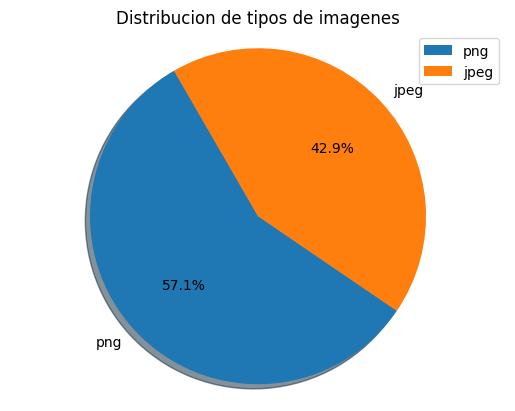

In [118]:
tipo_imagen = data_set['Tipo'].value_counts().sort_values(ascending=False) #extraemos los tipos, los contamos y los ordenamos de manera descendente
tipos = list(tipo_imagen.index) #listamos los tipos para la leyenda a un costado del grafico
#creamos el grafico de torta con los datos extraidos en la celda anterior
if len(tipos)!=0:
    plt.pie(tipo_imagen,labels = tipos,autopct='%1.1f%%',shadow=True, startangle=120, labeldistance= 1.1)
    plt.axis('equal')
    plt.legend(tipos)
    plt.title("Distribucion de tipos de imagenes")
    plt.show()
else:
    print('El archivo se encuentra vacio')

Calculo de los valores máximos de ancho y de alto de las imágenes clasificadas

In [119]:
#Extraemos las resoluciones del data set 
resoluciones = list(data_set['Resolución'])

#Como es una lista de strings, no de tuplas que es lo que queremos hacemos una serie de pasos en una linea de codigo
#Para convertilas en tuplas de enteros
#Hacemos un tuple de cada uno de los valores pasados a enteros 
tuplas = [tuple(map(int, tupla.strip('()').split(', '))) for tupla in resoluciones]

#Ahora con la lista de tuplas calculamos el alto y el ancho maximo
try:
    maximo_alto = max(resolucion[0] for resolucion in tuplas)
    maximo_ancho = max(resolucion[1] for resolucion in tuplas)
    print('La maxima altura es', maximo_alto, 'px')
    print('El maximo ancho es', maximo_ancho, 'px')
except(ValueError):
    print('El archivo esta vacio y no se puede hacer el calculo')

La maxima altura es 1200 px
El maximo ancho es 1200 px


Se informa cuáles son los 3 tags más utilizados

In [120]:
#Extraemos los tags del data set y eliminamos con dropna los valores NaN
tags = data_set['Etiquetas']
tags=tags.dropna()

#Ahora con estos datos extraidos hacemos un join para unirlos en una lista eliminandoles los numerales con replace
lista_tags = ' '.join(list(tags)).replace('#','').split()

#Con esta lista creamos un nuevo data frame llamado df_tags
datos_tags = {'etiquetas': lista_tags}
mas_populares = pd.DataFrame(data=datos_tags)

#De este data frame calculamos los mas populares con un value counts en descendente y extrayendo solo los 3 primeros
mas_populares = mas_populares['etiquetas'].value_counts().sort_values(ascending=False).head(3)

#Con estos tres datos mas populares creamos un data frame nuevo listo para mostrar como resultado
try:
    datos_mas_populares = {'etiqueta': list(mas_populares.index), 'usos': list(mas_populares.values)}
    tres_mas_populares = pd.DataFrame(data=datos_mas_populares, index=['1','2','3'])
    print(tres_mas_populares)
except(ValueError):
    print('No hay suficientes etiquetas para clasificar')

  etiqueta  usos
1   ELPEPE     2
2   abuelo     2
3     lolo     2


Con la lista de tags generar una nube de palabras

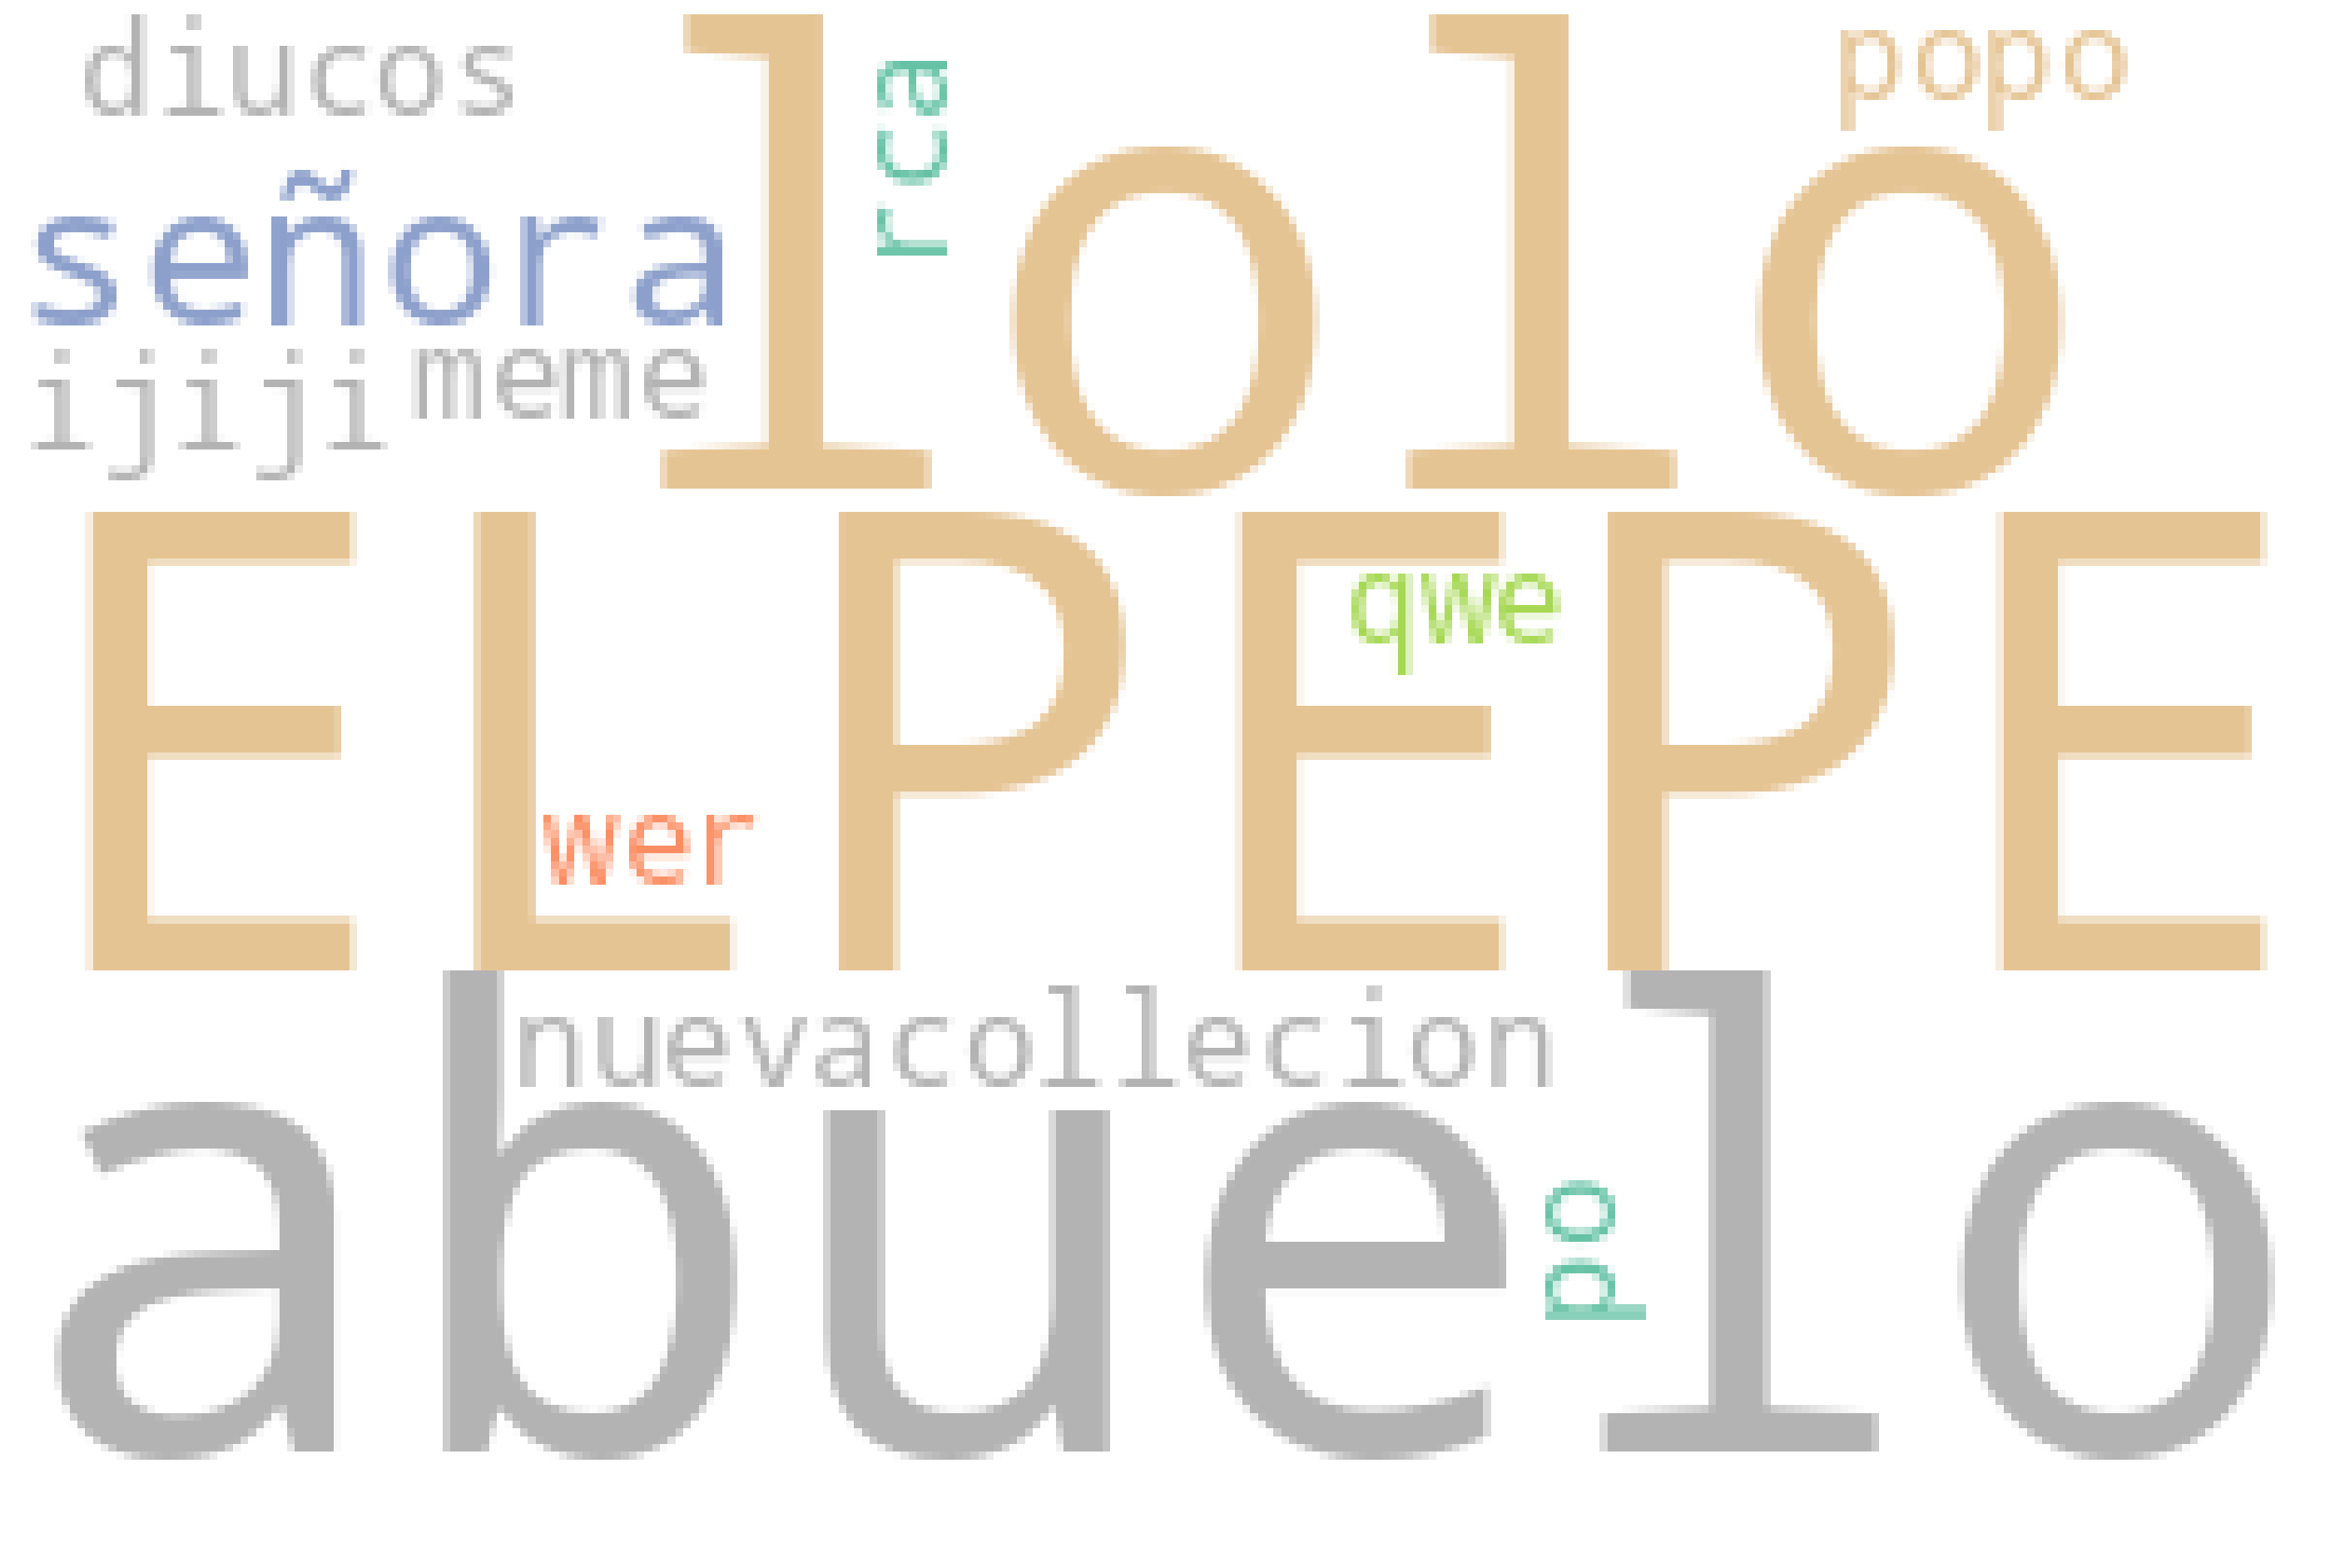

In [121]:
#Usamos como texto la lista de tags antes extraida para calcular el punto anterior y con wordcloud graficamos
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30)) #Tamaño de la figura
    plt.imshow(wordcloud)
    plt.axis("off");
    
palabras = ' '.join(list(tags)).replace('#','')
try:
    wordcloud = WordCloud(width = 300, height = 200, random_state=1, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(palabras)
    plot_cloud(wordcloud)
except(ValueError):
    print('Se necesita al menos una etiqueta para crear la nuba de palabras')

Generar un gráfico de dispersión para visualizar la relación entre el ancho y el alto
de las imágenes

In [122]:
#A partir del DataSet principal creamos un nuevo dataFrame extrayendo la resolucion separando el ancho y la altura de las imagenes 
#
df_resoluciones = pd.DataFrame(data = {'Altura': data_set['Resolución'].apply(lambda x:eval(x)[0]), 'Ancho': data_set['Resolución'].apply(lambda x:eval(x)[1])})
df_resoluciones #Imprimos la tabla ya que resulta util mostrar los valores a graficar

,Altura,Ancho
0,426,550
1,1200,1200
2,225,224
3,225,224
4,1054,1050
5,500,500
6,640,360
7,650,500
8,687,500
9,736,1041


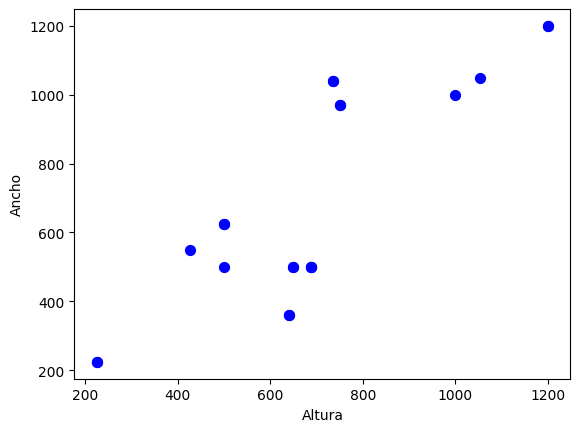

In [123]:
#Con la tabla de dos variables ya podemos hacer el grafico de dispersion entre ancho y altura
grafico_dispersion = df_resoluciones.plot.scatter(x='Altura',y='Ancho',c='Blue',s=50)
grafico_dispersion.plot()
plt.show()

Crear un gráfico de líneas para visualizar la evolución de la cantidad de
actualizaciones a lo largo del tiempo

In [124]:
#Para este caso vamos a necesitar el archivo csv de logs del sistema (perfiles.csv)
try:
    archivo_perfiles = os.path.join(os.path.dirname(constante.ROOT_PATH),"archivos",'perfiles.csv')
except(FileNotFoundError):
    print('No se encontro el archivo perfiles.csv en la carpeta de archivos')

In [125]:
#Creamos el dataFrame nuevo para perfiles
data_set2 = pd.read_csv(archivo_perfiles, encoding='utf-8')
data_set2['Timestamp']= pd.to_datetime(data_set2['Timestamp'], unit='s', origin='unix') #Mostramos el dato con el formato adecuado
data_set2['Timestamp']= data_set2['Timestamp'].dt.tz_localize('UTC') #Estabelcer la zona horaria como utc

# Convertir la hora a la zona horaria de Buenos Aires
zona_horaria_ba = pytz.timezone('America/Argentina/Buenos_Aires')
data_set2['Hora'] = data_set2['Timestamp'].dt.tz_convert(zona_horaria_ba).dt.time

#Dividimos la fecha y la hora, agregamos los dias y eliminamos la columna de timestamp
data_set2['Fecha'] = data_set2['Timestamp'].dt.date
data_set2['Dia'] = data_set2['Timestamp'].dt.day_name()
data_set2=data_set2.drop('Timestamp',axis=1)
data_set2 #Lo imprimimos en pantalla

,Nick,Operacion,Valores,Textos,Hora,Fecha,Dia
0,Dolo1234,Creo perfil,",",",",13:32:50,2023-06-29,Thursday
1,Juan2023,Creo perfil,",",",",21:53:19,2023-06-30,Friday
2,Joaco22,Creo perfil,",",",",14:33:19,2023-06-30,Friday
3,Moni21,Creo perfil,",",",",14:33:19,2023-06-30,Friday
4,Delva12,Creo perfil,",",",",14:33:19,2023-06-30,Friday
5,Dolo1234,Edito su perfil,",",",",18:25:42,2023-07-01,Saturday
6,Juan2023,Hizo cambios en la configuracion,",",",",18:26:18,2023-07-01,Saturday
7,Juan2023,nuevo_meme,meme3.png,elpepe;pepee,18:26:19,2023-07-01,Saturday
8,Joaco22,Modificacion de imagen clasificada,bildnis.jpg,",",22:14:24,2023-07-03,Monday
9,Joaco22,Hizo cambios en la configuracion,",",",",22:14:48,2023-07-03,Monday


In [126]:
#Extraemos solo las opreciones de actualizacion 
actualizaciones = data_set2[(data_set2['Operacion']== 'Modificacion de imagen clasificada')]
#Las agrupamos por fecha y las contabilizamos
actualizaciones = actualizaciones.groupby(['Fecha']).count()
#Nos quedamos solo con la columna de operacion
actualizaciones = actualizaciones['Operacion']

<Axes: xlabel='Fecha de actualizacion', ylabel='Cantidad de actualizaciones'>

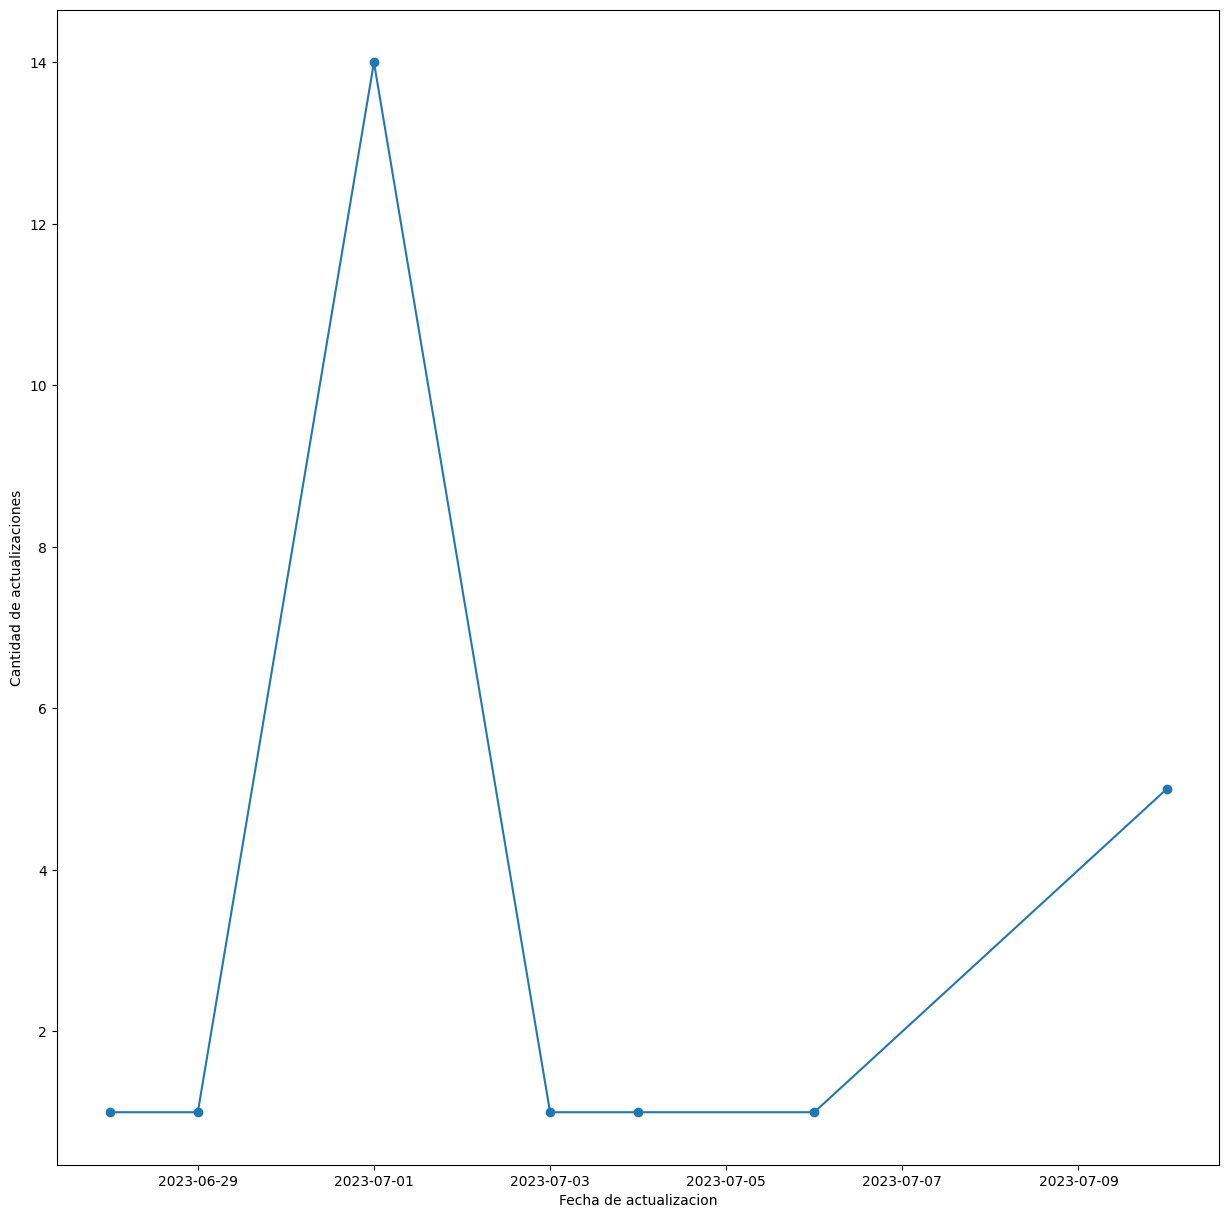

In [127]:
#Creamos el plot de 15x15 con sus respectivos labels
actualizaciones.plot(figsize=(15,15), xlabel='Fecha de actualizacion', ylabel='Cantidad de actualizaciones', marker='o')

En base a la fecha de última actualización, cantidad de cambios realizados para
cada día de la semana

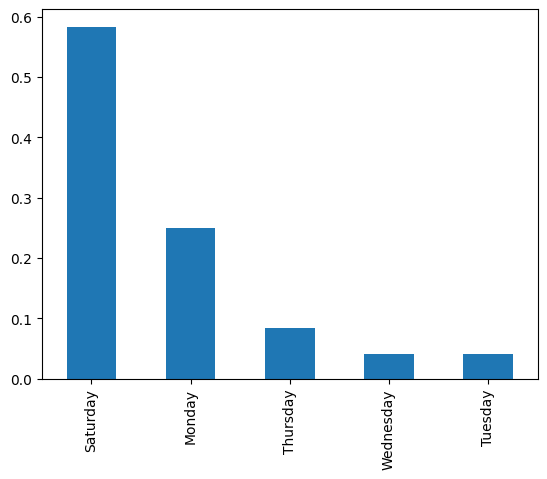

In [128]:
#Del segundo data set solo queremos los dias que se han realizado modficaciones
modificaciones = data_set2['Dia'][(data_set2['Operacion']== 'Modificacion de imagen clasificada')]

#Cuante las modificaciones por columna dia y las ploteo en forma de barra
try:
    mod_agrupadas = modificaciones.value_counts('Dia')
    mod_agrupadas.plot(kind="bar")
except(IndexError):
    print('El archivo se encuentra vacio y no se puede hacer el grafico')

Calculo del tamaño en bytes promedio de las imágenes actualizadas por cada perfil,
incluir los perfiles que no hayan realizado actualizaciones

In [129]:
#Del dataset2 filtramos solo las que son de actualizacion
actualizaciones = data_set2[(data_set2['Operacion']== 'Modificacion de imagen clasificada')]

#Ahora hacemos un join entre los dos csv con merge

#Primero hacemos un map para cambiar la ruta por el nombre del archivo
data_set['Ubicación'] = data_set['Ubicación'].map(lambda ruta: os.path.basename(ruta))

#Cambiamos el nombre para poder hacer un join con la palabra clave de nombre foto entre ambos dataframes
data_set = data_set.rename(columns={'Ubicación': 'Nombre foto'})
actualizaciones = actualizaciones.rename(columns={'Valores': 'Nombre foto'})

#Realizo el join con Nombre foto'
df_unido = pd.merge(actualizaciones, data_set, on='Nombre foto')
#Mostramos el nuevo df producto del merge
df_unido

,Nick,Operacion,Nombre foto,Textos,Hora,Fecha_x,Dia,Descripción,Resolución,Tamaño,Tipo,Etiquetas,Ultimo Perfil,Fecha_y
0,Joaco22,Modificacion de imagen clasificada,bildnis.jpg,",",22:14:24,2023-07-03,Monday,estilo barrroco,"(426, 550)",57149,jpeg,#señora,Joaco22,29/06/2023
1,Moni21,Modificacion de imagen clasificada,fuma 14.png,",",08:00:50,2023-06-28,Wednesday,NaN,"(1200, 1200)",2334084,png,#nuevacollecion #rca #diucos,Joaco22,29/06/2023
2,Joaco22,Modificacion de imagen clasificada,mexico2015.jpg,",",21:11:30,2023-07-10,Monday,NaN,"(1054, 1050)",257557,jpeg,NaN,Joaco22,29/06/2023
3,Joaco22,Modificacion de imagen clasificada,dubai2001.jpg,",",21:11:41,2023-07-10,Monday,NaN,"(500, 500)",54231,jpeg,NaN,Joaco22,29/06/2023
4,Joaco22,Modificacion de imagen clasificada,paraguay2022.jpg,",",21:12:00,2023-07-10,Monday,NaN,"(640, 360)",19106,jpeg,NaN,Joaco22,29/06/2023
5,Delva12,Modificacion de imagen clasificada,asado.png,",",15:58:10,2023-07-01,Saturday,NaN,"(687, 500)",204553,png,NaN,Delva12,29/06/2023
6,Delva12,Modificacion de imagen clasificada,iglesia.jpg,",",08:18:21,2023-07-10,Monday,NaN,"(736, 1041)",112888,jpeg,NaN,Delva12,29/06/2023
7,Delva12,Modificacion de imagen clasificada,comida.png,",",05:05:20,2023-07-04,Tuesday,NaN,"(750, 969)",280853,png,NaN,Delva12,29/06/2023
8,Delva12,Modificacion de imagen clasificada,tios.jpg,",",11:05:50,2023-07-10,Monday,NaN,"(687, 500)",204553,png,NaN,Delva12,29/06/2023
9,Juan2023,Modificacion de imagen clasificada,arbolito.jpg,",",16:15:01,2023-07-06,Thursday,NaN,"(650, 500)",130024,png,NaN,Juan2023,29/06/2023


In [130]:
#Ahora como vamos a necesitar todos los perfiles a pesar de que no hayan actualizado fotos los traemos del archivo json
try:
    archivo_perfiles = os.path.join(os.path.dirname(constante.ROOT_PATH),"archivos",'perfiles.json')
    with open (archivo_perfiles, encoding='utf-8') as file:
        perfiles = json.load(file)
    #Extraemos los nicks en una lista para posterior mente crear un nuevo data frame 
    nicks = list(map(lambda n: n['Alias'], perfiles))
except(FileNotFoundError):
    print('No se encontro el archivo de perfiles')
    nicks=[]

In [131]:
#Calculamos el tamaño de promedio de cada imagen actualizada por cada usuario
def calcular_promedio(nick):
    sus_imagenes = df_unido[(df_unido['Nick']==nick)]#filtro por nick
    promedio = sus_imagenes['Tamaño'].mean() #calculo usando mean()
    return promedio

promedios = [ calcular_promedio(nick) for nick in nicks] #para cada nick calculo su promedio

datos = {'Perfil':nicks, 'Tamaño promedio': promedios} #creamos el data frame

df_promedios = pd.DataFrame(data=datos).fillna(0) #a las columnas NaN las rellenamos con un 0
df_promedios

,Perfil,Tamaño promedio
0,Juan2023,2.769142e+05
1,Dolo1234,1.530212e+05
2,Joaco22,2.707283e+05
3,Moni21,2.334084e+06
4,Delva12,2.007118e+05
